## MLlib PySpark Logistic Regression
## Cruise Ship Info
They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Description: Measurements of ship size, capacity, crew, and age for 158 cruise ships.

Variables/Columns

* Ship Name 1-20
* Cruise Line 21-40
* Age (as of 2013) 46-48
* Tonnage (1000s of tons) 50-56
* passengers (100s) 58-64
* Length (100s of feet) 66-72
* Cabins (100s) 74-80
* Passenger Density 82-88
* Crew (100s) 90-96

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('Cruse info').getOrCreate()

In [0]:
df = spark.read.csv('dbfs:/FileStore/cruise_ship_info.csv', inferSchema = True, header=True)

In [0]:
df.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [0]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [0]:
print((df.count(), len(df.columns)))

(158, 9)


In [0]:
from pyspark.sql.functions import col, sum as _sum

In [0]:
# chech missing values
missing_val = df.select([_sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
missing_val.show()

+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [0]:
# check duplicated
dupliated = df.exceptAll(df.dropDuplicates())
dupliated.show()

+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [0]:
df.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [0]:
# describe data
df.select('Age', 'Tonnage', 'passengers', 'length', 'cabins',
           'passenger_density', 'crew').describe().display()

summary,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158,158,158,158,158,158,158
mean,15.689873417721518,71.28467088607599,18.45740506329114,8.130632911392404,8.830000000000005,39.90094936708861,7.794177215189873
stddev,7.615691058751413,37.229540025907866,9.677094775143416,1.793473548054825,4.4714172221480615,8.63921711391542,3.503486564627034
min,4,2.329,0.66,2.79,0.33,17.7,0.59
max,48,220.0,54.0,11.82,27.0,71.43,21.0


In [0]:
# convert dataframe pyspark to pandas
df_pd = df.toPandas()

In [0]:
import matplotlib.pyplot as plt 
import seaborn as sns

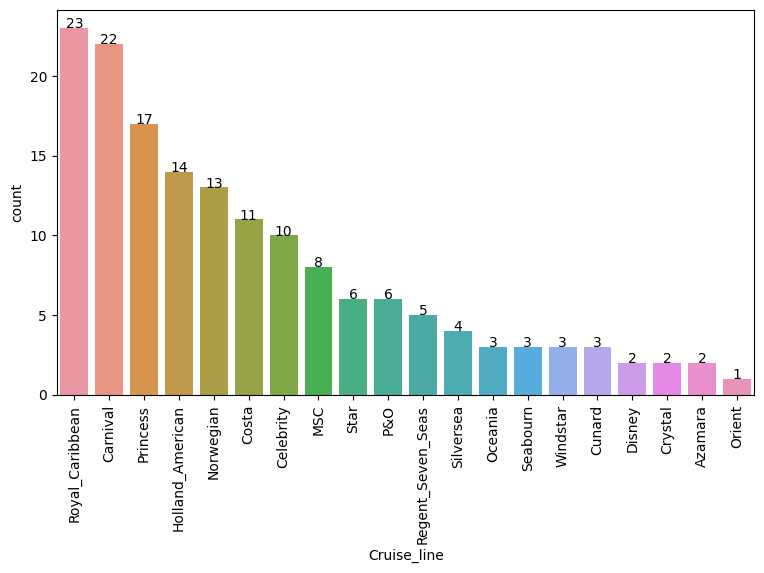

In [0]:
plt.figure(figsize=(9, 5), dpi=100)
ax = sns.countplot(x ='Cruise_line', order = df_pd['Cruise_line'].value_counts().index, data = df_pd)

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + p.get_width()/2, 
            y = height,
            s = '{:.0f}'.format(height), 
            ha = 'center'
            )
plt.xticks(rotation=90)
plt.show()

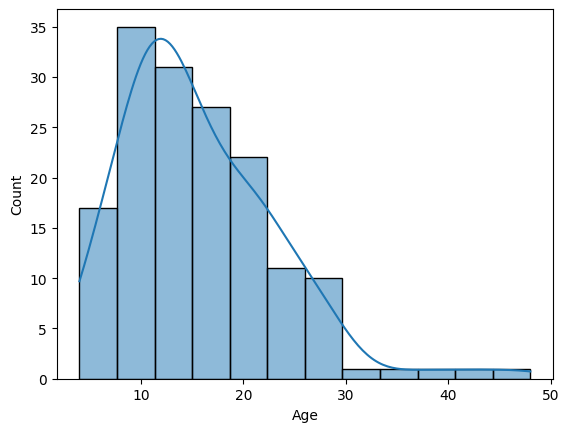

In [0]:
sns.histplot(x ='Age', data = df_pd,kde=True);

## Dealing Categorical Variable

In [0]:
df.groupBy('Cruise_line').count().orderBy(col('count').asc()).show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|           Orient|    1|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Cunard|    3|
|         Seabourn|    3|
|         Windstar|    3|
|          Oceania|    3|
|        Silversea|    4|
|Regent_Seven_Seas|    5|
|              P&O|    6|
|             Star|    6|
|              MSC|    8|
|        Celebrity|   10|
|            Costa|   11|
|        Norwegian|   13|
| Holland_American|   14|
|         Princess|   17|
|         Carnival|   22|
|  Royal_Caribbean|   23|
+-----------------+-----+



In [0]:
from pyspark.ml.feature import StringIndexer

In [0]:
indexer = StringIndexer(inputCol='Cruise_line', outputCol='cruise_cat')
indexed = indexer.fit(df).transform(df)
indexed.head(5)


[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_cat=16.0),
 Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_cat=16.0),
 Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7, cruise_cat=1.0),
 Row(Ship_name='Conquest', Cruise_line='Carnival', Age=11, Tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1, cruise_cat=1.0),
 Row(Ship_name='Destiny', Cruise_line='Carnival', Age=17, Tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0, cruise_cat=1.0)]

## Format for MLlib

In [0]:
from pyspark.ml.feature import VectorAssembler

In [0]:
indexed.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'cruise_cat']

In [0]:
assembler = VectorAssembler(inputCols=['Age', 'Tonnage', 'passengers','length',
                                        'cabins', 'passenger_density','cruise_cat'], 
                            outputCol='features')

In [0]:
output = assembler.transform(indexed)

In [0]:
output.limit(5).display()

Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew,cruise_cat,features
Journey,Azamara,6,30.276999999999997,6.94,5.94,3.55,42.64,3.55,16.0,"Map(vectorType -> dense, length -> 7, values -> List(6.0, 30.276999999999997, 6.94, 5.94, 3.55, 42.64, 16.0))"
Quest,Azamara,6,30.276999999999997,6.94,5.94,3.55,42.64,3.55,16.0,"Map(vectorType -> dense, length -> 7, values -> List(6.0, 30.276999999999997, 6.94, 5.94, 3.55, 42.64, 16.0))"
Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.8,6.7,1.0,"Map(vectorType -> dense, length -> 7, values -> List(26.0, 47.262, 14.86, 7.22, 7.43, 31.8, 1.0))"
Conquest,Carnival,11,110.0,29.74,9.53,14.88,36.99,19.1,1.0,"Map(vectorType -> dense, length -> 7, values -> List(11.0, 110.0, 29.74, 9.53, 14.88, 36.99, 1.0))"
Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.0,1.0,"Map(vectorType -> dense, length -> 7, values -> List(17.0, 101.353, 26.42, 8.92, 13.21, 38.36, 1.0))"


## Standard Sclaler

In [0]:
from pyspark.ml.feature import StandardScaler

In [0]:
scaler = StandardScaler(inputCol='features', outputCol='scalerfeature', withStd=True, withMean =False)

In [0]:
scaler_df = scaler.fit(output).transform(output)

In [0]:
scaler_df.limit(5).display()

Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew,cruise_cat,features,scalerfeature
Journey,Azamara,6,30.276999999999997,6.94,5.94,3.55,42.64,3.55,16.0,"Map(vectorType -> dense, length -> 7, values -> List(6.0, 30.276999999999997, 6.94, 5.94, 3.55, 42.64, 16.0))","Map(vectorType -> dense, length -> 7, values -> List(0.7878470848821034, 0.8132520568057078, 0.7171573867216928, 3.3120087031350067, 0.7939317275999097, 4.9356324117978945, 3.3622312852191634))"
Quest,Azamara,6,30.276999999999997,6.94,5.94,3.55,42.64,3.55,16.0,"Map(vectorType -> dense, length -> 7, values -> List(6.0, 30.276999999999997, 6.94, 5.94, 3.55, 42.64, 16.0))","Map(vectorType -> dense, length -> 7, values -> List(0.7878470848821034, 0.8132520568057078, 0.7171573867216928, 3.3120087031350067, 0.7939317275999097, 4.9356324117978945, 3.3622312852191634))"
Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.8,6.7,1.0,"Map(vectorType -> dense, length -> 7, values -> List(26.0, 47.262, 14.86, 7.22, 7.43, 31.8, 1.0))","Map(vectorType -> dense, length -> 7, values -> List(3.414004034489115, 1.2694757970985027, 1.5355848366980338, 4.025707548255008, 1.6616655594555858, 3.680889087597867, 0.2101394553261977))"
Conquest,Carnival,11,110.0,29.74,9.53,14.88,36.99,19.1,1.0,"Map(vectorType -> dense, length -> 7, values -> List(11.0, 110.0, 29.74, 9.53, 14.88, 36.99, 1.0))","Map(vectorType -> dense, length -> 7, values -> List(1.4443863222838562, 2.9546430045456242, 3.0732364093808564, 5.31371093280751, 3.3278039737145515, 4.28163796698884, 0.2101394553261977))"
Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.0,1.0,"Map(vectorType -> dense, length -> 7, values -> List(17.0, 101.353, 26.42, 8.92, 13.21, 38.36, 1.0))","Map(vectorType -> dense, length -> 7, values -> List(2.2322334071659595, 2.7223812039973874, 2.7301582359059258, 4.97358882693001, 2.9543205976323406, 4.440217150951389, 0.2101394553261977))"


In [0]:
final_df = scaler_df.select('crew', 'scalerfeature')

In [0]:
final_df.show()

+----+--------------------+
|crew|       scalerfeature|
+----+--------------------+
|3.55|[0.78784708488210...|
|3.55|[0.78784708488210...|
| 6.7|[3.41400403448911...|
|19.1|[1.44438632228385...|
|10.0|[2.23223340716595...|
| 9.2|[2.88877264456771...|
| 9.2|[1.96961771220525...|
| 9.2|[3.02008049204806...|
| 9.2|[2.49484910212666...|
|11.5|[0.78784708488210...|
|11.6|[1.31307847480350...|
| 6.6|[3.67661972944981...|
| 9.2|[2.36354125464631...|
| 9.2|[2.23223340716595...|
| 9.3|[1.44438632228385...|
|11.6|[1.05046277984280...|
|10.3|[1.18177062732315...|
| 9.2|[1.96961771220525...|
| 9.3|[1.57569416976420...|
| 9.2|[2.62615694960701...|
+----+--------------------+
only showing top 20 rows



## Train Test Split

In [0]:
train, test = final_df.randomSplit([0.7, 0.3])

## Create Model

In [0]:
from pyspark.ml.regression import LinearRegression

In [0]:
lr = LinearRegression(featuresCol='scalerfeature', labelCol='crew')

In [0]:
# fit the model 
lrModel = lr.fit(train)

In [0]:
# print coefficients and intercept for linear regression
print('Coefficients : {} , Intercept : {}'.format(lrModel.coefficients, lrModel.intercept))

Coefficients : [-0.08630107635810601,0.4757018438343566,-1.2818041705615733,0.605858578794889,3.7632590191788657,-0.006665760803215711,0.25780229576427205] , Intercept : -0.8346097195857818


## Evaluate

In [0]:
test_result = lrModel.evaluate(test)

In [0]:
print('RMSE : {}'.format(test_result.rootMeanSquaredError))
print('MSE : {}'.format(test_result.meanSquaredError))
print('R2 : {}'.format(test_result.r2))

RMSE : 0.7066540394229885
MSE : 0.4993599314328266
R2 : 0.9645527713844144


In [0]:
# result r2 0.96
from pyspark.sql.functions import corr

In [0]:
# check the data little closer
df.select(corr('crew', 'passengers')).show()

+----------------------+
|corr(crew, passengers)|
+----------------------+
|    0.9152341306065384|
+----------------------+



In [0]:
df.select(corr('crew','cabins')).show()

+------------------+
|corr(crew, cabins)|
+------------------+
|0.9508226063578497|
+------------------+



## Good Jobs.!!